In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# nltk.download('punkt')   Package punkt is already up-to-date!
# nltk.download("stopwords")    Package stopwords is already up-to-date!


from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')  Package wordnet is already up-to-date!

from wordcloud import WordCloud,STOPWORDS

# IMPORT FUZZYWUZZY
from fuzzywuzzy import fuzz

from sklearn.manifold import TSNE

import time
# start_time =time.clock()
# print(time.clock()-start_time,"seconds")
LEMATIZE = WordNetLemmatizer()
STOP_WORDS=stopwords.words("english")

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
Qd = pd.read_csv(r"Z:\DS DATA\train.csv")
print(Qd.shape)
Qd.head()


(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print(Qd["is_duplicate"].value_counts())

0    255027
1    149263
Name: is_duplicate, dtype: int64


In [4]:
start_time =time.clock()
def emptly(x):
    if len(str(x['question1']))<=6:
        x['question1']=""
    if len(str(x['question2']))<=6:
        x['question2']=""
    if x["is_duplicate"]==0 and (x['question1']=="" or x['question2']==""):
        x['is_duplicate']=1
    return x
Qd = Qd.apply(emptly,axis=1)
print(time.clock()-start_time,"seconds")       

73.1658506 seconds


In [5]:
print(Qd["is_duplicate"].value_counts())

0    254952
1    149338
Name: is_duplicate, dtype: int64


In [6]:
Qids = pd.Series(Qd['qid1'].tolist()+Qd['qid2'].tolist())
unique_Qids = Qids.unique()

Qids_counts=Qids.value_counts()
print('Total of qid1 + qid2: {} \n No. of Unique Qids: {} \n No. of Duplicate Quds:{}'
      .format(len(Qids),len(unique_Qids),len(Qids)-len(unique_Qids)))

Total of qid1 + qid2: 808580 
 No. of Unique Qids: 537933 
 No. of Duplicate Quds:270647


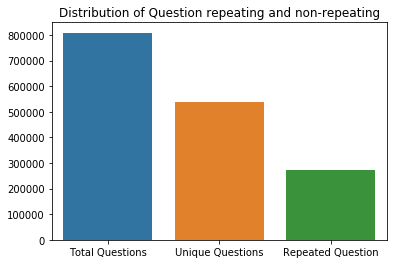

In [7]:
x=["Total Questions","Unique Questions","Repeated Question"]
y=[len(Qids),len(Qids.unique()),len(Qids)-len(Qids.unique())]
plt.title("Distribution of Question repeating and non-repeating")
sns.barplot(x,y)
plt.show()

In [8]:
start_time =time.clock()
def preprocess(x):
    x=re.sub("  *"," ",re.sub("<.*?>"," ",str(x).lower()))
#     x=re.sub("  *"," ",re.sub('<[a-zA-Z]*>|</[a-zA-Z]*>',' ',str(x))).lower()
    x=x.replace("%","percent").replace("$","dollar").replace("₹","rupees").replace("rs","rupees").replace(
    "i'm","i am").replace("don't","do not").replace("&","and").replace("we're","we are").replace("you're","you are").replace(
        "they're","they are").replace("he's","he is").replace("have't","have not").replace(
        "has't","has not").replace("is't","is not").replace("didn't","did not").replace("he'll","he will").replace(
    "she'll","she will").replace("it'll","it will").replace(',000',"k").replace("000,000","m").replace("'ve","have").replace(
        '000',"k").replace("000000","m").replace("/","").replace("?","").replace("(","").replace(")","").replace(
        "'s","")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x=re.sub("[^a-z0-9-]"," ",x)
    return  x
        
Qd["question1"] = Qd["question1"].apply(preprocess)
Qd["question2"] = Qd["question2"].apply(preprocess)
print(time.clock()-start_time,"seconds")       


28.89247370000001 seconds


In [9]:
start_time =time.clock()
# Frequency of qid1 and qid2 in 
Qd['freq_qid1'] = Qd.groupby(Qd["qid1"])["qid1"].transform("count")
Qd['freq_qid2'] = Qd.groupby(Qd["qid2"])["qid2"].transform("count")

# # total no of alphabits in question text 
Qd['q1_alphabit_len'] = Qd['question1'].str.len()
Qd['q2_alphabit_len'] = Qd['question2'].str.len()

# counts of word in each Questions
Qd['q1_n_unique_words'] = Qd["question1"].apply(lambda x: len(set(x.split())))
Qd['q2_n_unique_words'] = Qd["question2"].apply(lambda x: len(set(x.split())))

# Union of Question 1 and Question 2
Qd["q1_union_q2"] = Qd.apply(lambda w: (len(set(w['question1'].split()).union(set(w['question2'].split()))))*1.0,axis=1)

# Intersection of Question 1 and Question 2
Qd["q1_intersec_q2"] = Qd.apply(lambda w: (len(set(w['question1'].split()).intersection(set(w['question1'].split()))))*1.0,axis=1)

#total number of words in
Qd["total_unique_words"] = Qd.apply(lambda w: (len(set(w["question1"].split()))+len(set(w["question2"].split())))*1.0,axis=1)

#Words share of Intersectioned words outof Union words of Q1 and Q2
Qd['word_share']= (Qd["q1_intersec_q2"]/Qd["total_unique_words"])*1.0


# Intersection Divided by Union of Words----
Qd["intr_by_union"] = (Qd["q1_intersec_q2"]/Qd["q1_union_q2"])*1.0

# Intersected words of q1 and q1 DIFFERENCE union words of q1 and q1 
Qd["intr_diff_union"] = Qd.apply(lambda x: abs(x["q1_intersec_q2"] - x["q1_union_q2"]),axis=1)

# sum of Frequency of Q1 and Q2
Qd["fq1_pls_fq2"] = Qd['freq_qid1']+Qd['freq_qid2']

# Difference of Frequency of Q1 and Q2
Qd["fq1_diff_fq2"] = abs(Qd['freq_qid1']-Qd['freq_qid2'])


print(Qd.shape)
print(time.clock()-start_time,"seconds")       



(404290, 20)
56.41870230000001 seconds


In [10]:
# computing common_word_count_min cwc_min
start_time =time.clock()

SAFE_DIV = 0.0001
def extract_features(x):
    
    global SAFE_DIV
    q1_token=word_tokenize(x["question1"])
    q2_token=word_tokenize(x["question2"])
    
    q1_words = set([word for word in q1_token if word not in STOP_WORDS])
    q2_words = set([word for word in q2_token if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_token if word in STOP_WORDS])
    q2_stops = set([word for word in q2_token if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_token).intersection(set(q2_token)))
    
    cwc_min=0
    cwc_max=0
#     MIN MAX FOR WORDS
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)  # MAX
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV) # MIN

#     MIN MAX FOR STOP WORDS
    csc_min=0
    csc_max=0
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)  # MAX
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV) # MIN
    
#     MIN MAX FOR TOKENS
    ctc_min=0
    ctc_max=0
    ctc_max = common_token_count / (max(len(q1_token), len(q2_token)) + SAFE_DIV)  # MAX
    ctc_min = common_token_count / (min(len(q1_token), len(q2_token)) + SAFE_DIV) # MIN

#     LAST WORD FIRST WORD DIFF. LAST WORD DIFF. ABSOLUTE DIFF. RATION B/W TOKENS
    if len(q1_token)<=0 or len(q2_token)<=0:
        fw_com =0
        lw_com =0
    else:
        fw_com = int(q1_token[0]==q2_token[0])
        lw_com = int(q1_token[-1]==q2_token[-1])
    abs_diff= abs(len(q1_token)-len(q2_token))
    ratio = (len(q1_token)+len(q2_token)) / 2
    
    return cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, fw_com, lw_com, abs_diff, ratio
    
Qd[["cwc_min","cwc_max","csc_min","csc_max","ctc_min","ctc_max","fw_com","lw_com","abs_diff","ratio"]] = Qd.apply(extract_features,axis=1,result_type="expand")

print(Qd.shape)
print(time.clock()-start_time,"seconds")       


(404290, 30)
268.44763389999997 seconds


In [11]:
start_time =time.clock()
def fuzzyfeatures(x):
    token_set_ratio = fuzz.token_set_ratio(x["question1"],x["question2"])
    token_sort_ratio = fuzz.token_sort_ratio(x["question1"],x["question2"])
    fuzz_ratio = fuzz.QRatio (x["question1"],x["question2"])
    partial_ratio = fuzz.partial_ratio(x["question1"],x["question2"])

    return token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio

Qd[["token_set_ratio","token_sort_ratio","fuzz_ratio","partial_ratio"]]=Qd.apply(fuzzyfeatures,axis=1,result_type='expand')

print(Qd.shape)
print(time.clock()-start_time,"seconds")       


(404290, 34)
1575.4841339 seconds


In [12]:

start_time =time.clock()
def lematize(x):
    token=word_tokenize(x)
    l=[]
    if len(token)>=1:
        for i in token:
            l.append(LEMATIZE.lemmatize(i))
        return " ".join(l)
    else:
        return x
Qd["question1"] = Qd["question1"].apply(lematize)
Qd["question2"]=Qd["question2"].apply(lematize)

print(time.clock()-start_time,"seconds")       

165.26818980000007 seconds


In [16]:
Qd.to_csv(r"Z:\DS DATA\result.csv")

In [13]:
start_time =time.clock()
glove = open(r'Z:\DS DATA\glove.6B.300d.txt',encoding="utf8")

glovedict={}
for line in glove:
    l=line.split()
    glovedict[l[0]] =np.asarray(l[1:])
print(time.clock()-start_time,"seconds")

47.070462099999986 seconds


In [14]:
# glovedict.to_pickle(r"Z:\DS DATA\glovedict.pickle")
# Qd = pd.read_pickle(r"Z:\DS DATA\Qd.pickle")

In [15]:
start_time =time.clock()
text = list(Qd["question1"])+list(Qd['question2'])
print(len(text))
print(time.clock()-start_time,"seconds")

808580
4.800945299999967 seconds


In [17]:
Qd.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1_alphabit_len', 'q2_alphabit_len',
       'q1_n_unique_words', 'q2_n_unique_words', 'q1_union_q2',
       'q1_intersec_q2', 'total_unique_words', 'word_share', 'intr_by_union',
       'intr_diff_union', 'fq1_pls_fq2', 'fq1_diff_fq2', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'fw_com', 'lw_com',
       'abs_diff', 'ratio', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'partial_ratio'],
      dtype='object')

In [18]:
Qd.drop(columns=["id","qid1","qid2","question1","question2"],axis=1,inplace=True)
Qd.columns

Index(['is_duplicate', 'freq_qid1', 'freq_qid2', 'q1_alphabit_len',
       'q2_alphabit_len', 'q1_n_unique_words', 'q2_n_unique_words',
       'q1_union_q2', 'q1_intersec_q2', 'total_unique_words', 'word_share',
       'intr_by_union', 'intr_diff_union', 'fq1_pls_fq2', 'fq1_diff_fq2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'fw_com', 'lw_com', 'abs_diff', 'ratio', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'partial_ratio'],
      dtype='object')

In [20]:
Qd.to_csv(r"Z:\DS DATA\modeldf.csv",index=False)

In [24]:
# df=pd.read_csv(r"Z:\DS DATA\modeldf.csv")
df.head()

,is_duplicate,freq_qid1,freq_qid2,q1_alphabit_len,q2_alphabit_len,q1_n_unique_words,q2_n_unique_words,q1_union_q2,q1_intersec_q2,total_unique_words,...,ctc_min,ctc_max,fw_com,lw_com,abs_diff,ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio
0,0,1,1,65,56,12,11,12.0,12.0,23.0,...,0.916659,0.785709,1.0,0.0,2.0,13.0,100,93,93,100
1,0,4,1,48,85,8,12,15.0,8.0,20.0,...,0.624992,0.384612,1.0,0.0,5.0,10.5,86,63,65,73
2,0,1,1,72,58,14,10,20.0,14.0,24.0,...,0.399996,0.285712,1.0,0.0,4.0,12.0,63,63,43,46
3,0,1,1,48,63,10,10,20.0,10.0,20.0,...,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,11
4,0,3,1,75,38,13,7,16.0,13.0,20.0,...,0.571420,0.307690,1.0,0.0,6.0,10.0,67,47,35,55


In [157]:
start_time =time.clock()

tfidf = TfidfVectorizer()
# countvect =CountVectorizer()
tfidf.fit_transform(text)
word2vec = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

print(time.clock()-start_time,"seconds")

23.58931600001233 seconds


In [158]:
start_time =time.clock()
A = np.float64(0.001)
def get_data(x):
    l1=[]
    q1= x.split()
    for i in q1:
        l1.append(word2vec.get(i,A))
    return np.asarray(l1,np.float64)
Qd['q1_tfidf']=Qd['question1'].apply(get_data)
Qd['q2_tfidf']=Qd['question2'].apply(get_data)
print(time.clock()-start_time,"seconds")

6.775325700000394 seconds


In [82]:
print(Qd.shape)
Qd.head()

(404290, 36)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_alphabit_len,q2_alphabit_len,...,fw_com,lw_com,abs_diff,ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio,q2_tfidf,q1_tfidf
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,65,56,...,1.0,0.0,2.0,13.0,100,93,93,100,"[1.9401179276160585, 2.148627941594631, 1.9737...","[1.9401179276160585, 2.148627941594631, 1.9737..."
1,1,3,4,what is the story of kohinoor koh-i-noor diamond,what would happen if the indian government sto...,0,4,1,48,85,...,1.0,0.0,5.0,10.5,86,63,65,73,"[1.9401179276160585, 4.56878351609414, 6.09468...","[1.9401179276160585, 2.148627941594631, 1.9737..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,72,58,...,1.0,0.0,4.0,12.0,63,63,43,46,"[2.316706962014094, 2.941251109868922, 6.76272...","[2.316706962014094, 2.941251109868922, 0.001, ..."
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,1,1,48,63,...,0.0,0.0,2.0,12.0,28,24,9,11,"[5.340008444254631, 1.9737861762729119, 9.6685...","[3.291040291408146, 4.873425895984985, 0.001, ..."
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,75,38,...,1.0,0.0,6.0,10.0,67,47,35,55,"[3.9264356237758657, 8.558030824473809, 4.5687...","[3.9264356237758657, 4.658790593501525, 10.272..."


In [162]:
Qd.columns

(404290, 36)